In [1]:
using CSV, DataFrames
using LinearAlgebra
using MultivariateStats
using Distributions
using Plots
df = CSV.File("./price_df_clean.tsv") |> DataFrame;

In [2]:
using Convex, SCS

In [3]:
rename!(df,:Column1=>:time);

In [4]:
pr_value=Matrix(df[:,2:end]);

In [5]:
df_r = CSV.File("./df_sim_r.csv") |> DataFrame;

In [6]:
df_v =Matrix(df_r);

In [7]:
function return_price(return_df, price)
    # transform return data to price data
    length=size(return_df)[1]
    return_df[1,:] .=price.* return_df[1,:] .+ price 
    for i=2:length
        return_df[i,:] .=return_df[i-1,:].* return_df[i,:] .+ return_df[i-1,:]       
    end
end

return_price (generic function with 1 method)

In [8]:
price=pr_value[1,:];
df_p=copy(df_v);
return_price(df_p,price);

In [9]:
df_p=[price df_p']';

In [62]:
function get_win(df,start,len)
    win=df[start:start+len-1,:]
    return win
end

get_win (generic function with 1 method)

In [11]:
function opt_solver(exp_r,cov_f)    
    n = length(exp_r)
    x = Variable(n)
    x_lower = 0.0
    x_upper = 1
    ret  = dot(x,exp_r)
    #risk = quadform(x,cov_f)
    P = real(sqrt(Matrix(cov_f)))
    risk= square(norm2(P * x)) # norm2 of second_order_cone/norm2.jl
    qp_min = -ret+0.5*risk
    p = minimize(qp_min,
                  sum(x) == 1,
                  x_lower <= x,
                  x <= x_upper );
    solve!(p, () -> SCS.Optimizer(verbose=false),verbose=false);
    x.value
    return x.value
end

opt_solver (generic function with 1 method)

In [12]:
function cov_addcash(cov_r)
    # fix covariance matrix with return of cash 
    n=size(cov_r)[1]
    zero1=zeros(1,n)
    cov_f=vcat(cov_r,zero1);
    zero1=hcat(zero1,0)
    cov_f=hcat(cov_f,zero1')
    return cov_f
end

cov_addcash (generic function with 1 method)

In [13]:
function fra_filter(frac_or,threshold)
    b=frac_or.>=threshold
    index_asset=findall(b)
    return index_asset
end 

fra_filter (generic function with 1 method)

In [44]:
function single_win_frac(df_v,test_start,win_len,risk_free)
    window=get_win(df_v,test_start,win_len);
    cov_or=cov(window);
    mu=DataFrames.mean(window,dims=1);
    mu_c=hcat(mu,risk_free);
    cov_rf=cov_addcash(cov_or);
    fraction_raw=vec(opt_solver(mu_c,cov_rf));
    return fraction_raw
end 

single_win_frac (generic function with 1 method)

In [15]:
function total_asset(asset,stock_num,new_price,eff_fra,rate)
    stock_asset=stock_account(stock_num,new_price)
    #print("stock_asset=",stock_asset,"\n")
    cash_balance=cash_account(asset,eff_fra,rate)
    total_asset=stock_asset+cash_balance
    return total_asset  
end

total_asset (generic function with 1 method)

In [16]:
function asset_allocate(asset,fraction,price)
    stock_asset=asset*fraction;
    stock_num=stock_asset./ price
    return stock_num
end

asset_allocate (generic function with 1 method)

In [17]:
function stock_account(stock_num,new_price)
    stock_asset= stock_num'*new_price
    return stock_asset
end

stock_account (generic function with 1 method)

In [18]:
function cash_account(asset,eff_frac,rate)
    fra=1-sum(eff_frac)
    cash=asset*fra
    return cash
end

cash_account (generic function with 1 method)

In [19]:
function simulation_trade(start::Int, test_interval::Int, win_len::Int, risk_free::Float64, asset::Float64, threshold::Float64)
    fracton_raw = single_win_frac(df_v,start,win_len,risk_free)
    id_v = fra_filter(fracton_raw[1:end-1],0.0001)
    valid_fraction = fracton_raw[id_v]
    price = df_p[win_len+start,id_v]
    stock_num = asset_allocate(asset,valid_fraction,price)
    #price=df_p[win_len+2,id_v]
    asset_arr = [asset]
    for i = 1:test_interval
        if length(id_v) > 0
            price_n = df_p[win_len+i+start,id_v]
            asset = total_asset(asset,stock_num,price_n,valid_fraction,risk_free)
        else
            asset = asset*(1+risk_free)
        end
        fracton_raw = single_win_frac(df_v,start+i,win_len,risk_free)
        id_v = fra_filter(fracton_raw[1:end-1],threshold)
        valid_fraction = fracton_raw[id_v]
        price_s = df_p[win_len+i+start,id_v]
        stock_num = asset_allocate(asset,valid_fraction,price_s)
        asset_arr = [asset_arr asset]
    end
    return asset_arr
end

simulation_trade (generic function with 1 method)

In [91]:
function simulation_trade(start::Int, test_interval::Int, prior::Int, win_len::Int, risk_free::Float64, asset::Float64, threshold::Float64)
    fracton_raw = single_win_frac(df_v,start,prior,risk_free)
    id_v = fra_filter(fracton_raw[1:end-1],0.0001)
    print("id_v=",id_v,"\n")
    valid_fraction = fracton_raw[id_v]
    price = df_p[win_len+start,id_v]
    print("start=",win_len+start,"\n")
    stock_num = asset_allocate(asset,valid_fraction,price)
    print("valid_fraction=",valid_fraction,"\n")
    asset_arr = [asset]
    for i = 1:test_interval
        if length(id_v) > 0
            price_n = df_p[win_len+i+start,id_v]
            asset = total_asset(asset,stock_num,price_n,valid_fraction,risk_free)
        else
            asset = asset*(1+risk_free)
        end
        price_s = df_p[win_len+i+start,id_v]
        stock_num = asset_allocate(asset,valid_fraction,price_s)
        asset_arr = [asset_arr asset]
    end
    return asset_arr
end

simulation_trade (generic function with 2 methods)

In [94]:
function simulation_trade1(start::Int, test_interval::Int, prior::Int, win_len::Int, risk_free::Float64, asset::Float64, threshold::Float64)
    fracton_raw = single_win_frac(df_v,start,prior,risk_free)
    id_v = fra_filter(fracton_raw[1:end-1],0.0001)
    print("id_v=",id_v,"\n")
    valid_fraction = fracton_raw[id_v]
    price = df_p[win_len+start,id_v]
    print("start=",win_len+start,"\n")
    stock_num = asset_allocate(asset,valid_fraction,price)
    print("valid_fraction=",valid_fraction,"\n")
    asset_arr = [asset]
    for i = 1:test_interval
        if length(id_v) > 0
            price_n = df_p[win_len+i+start,id_v]
            asset = total_asset(asset,stock_num,price_n,valid_fraction,risk_free)
        else
            asset = asset*(1+risk_free)
        end
        price_s = df_p[win_len+i+start,id_v]
        asset_arr = [asset_arr asset]
    end
    return asset_arr
end

simulation_trade1 (generic function with 1 method)

In [99]:
start = 1;
test_interval = 900;
risk_free = 0.0001
prior=1200
asset = 100000.
threshold = 0.00001
asset_arr = Matrix{Float64}(undef,8,901)
len_ls = Vector(60:20:200)
for i in Vector(1:length(len_ls))
    tem=simulation_trade(start+200-len_ls[i], test_interval, prior, len_ls[i], risk_free, asset, threshold)
    asset_arr[i,:] = vec(tem);
end

id_v=[17, 53]
start=201
valid_fraction=[0.7263073183210093, 0.273691973720097]
id_v=[17, 49, 53, 60]
start=201
valid_fraction=[0.26821671364411487, 0.1285186233368694, 0.593916510976972, 0.00934341286790428]
id_v=[17, 53]
start=201
valid_fraction=[0.25160098737901054, 0.7483925098761864]
id_v=[17, 49, 53, 60]
start=201
valid_fraction=[0.0260645041383816, 0.14273471887122854, 0.6818079097422468, 0.1493681615185977]
id_v=[17, 32, 53, 60]
start=201
valid_fraction=[0.08776701994217921, 0.42083931097651345, 0.49021407951958046, 0.0011843590282422296]
id_v=[32, 60]
start=201
valid_fraction=[0.5558900376684685, 0.44411666174287845]
id_v=[32, 60]
start=201
valid_fraction=[0.6080204978622356, 0.39195865586291584]
id_v=[32, 60]
start=201
valid_fraction=[0.5583474152663834, 0.4416067553271707]


In [97]:
start = 1;
test_interval = 900;
risk_free = 0.0001
prior=1200
asset = 100000.
threshold = 0.00001
asset_arr1 = Matrix{Float64}(undef,8,901)
len_ls = Vector(60:20:200)
for i in Vector(1:length(len_ls))
    tem=simulation_trade1(start+200-len_ls[i], test_interval, prior, len_ls[i], risk_free, asset, threshold)
    asset_arr1[i,:] = vec(tem);
end

id_v=[17, 53]
start=201
valid_fraction=[0.7263073183210093, 0.273691973720097]
id_v=[17, 49, 53, 60]
start=201
valid_fraction=[0.26821671364411487, 0.1285186233368694, 0.593916510976972, 0.00934341286790428]
id_v=[17, 53]
start=201
valid_fraction=[0.25160098737901054, 0.7483925098761864]
id_v=[17, 49, 53, 60]
start=201
valid_fraction=[0.0260645041383816, 0.14273471887122854, 0.6818079097422468, 0.1493681615185977]
id_v=[17, 32, 53, 60]
start=201
valid_fraction=[0.08776701994217921, 0.42083931097651345, 0.49021407951958046, 0.0011843590282422296]
id_v=[32, 60]
start=201
valid_fraction=[0.5558900376684685, 0.44411666174287845]
id_v=[32, 60]
start=201
valid_fraction=[0.6080204978622356, 0.39195865586291584]
id_v=[32, 60]
start=201
valid_fraction=[0.5583474152663834, 0.4416067553271707]


In [100]:
asset_arr

8×901 Array{Float64,2}:
 100000.0       1.00552e5      1.00679e5  …       1.52189e5  1.51948e5
 100000.0       1.01047e5      1.00521e5          1.84288e5  1.83084e5
 100000.0       1.01329e5      1.0032e5           1.91801e5  1.90285e5
 100000.0       1.01336e5      1.00227e5          2.05776e5  2.03741e5
 100000.0       1.02142e5  99996.5           166625.0        1.63816e5
 100000.0       1.02208e5  99451.8        …       1.61908e5  1.58504e5
 100000.0  102305.0        99474.6                1.55858e5  1.52466e5
 100000.0       1.02212e5  99452.9                1.61621e5  1.58217e5

In [120]:
round.(mean(asset_arr,dims=2)./asset_arr[1:end,1],digits=3)'

1×8 Adjoint{Float64,Array{Float64,2}}:
 1.617  1.795  1.861  1.86  2.04  1.909  1.936  1.911

In [121]:
round.(mean(asset_arr1,dims=2)./asset_arr[1:end,1],digits=3)'

1×8 Adjoint{Float64,Array{Float64,2}}:
 1.599  1.757  1.838  1.817  1.977  1.868  1.895  1.869

In [117]:
(start+200 .-len_ls)'

1×8 Adjoint{Int64,Array{Int64,1}}:
 141  121  101  81  61  41  21  1

In [98]:
asset_arr1

8×901 Array{Float64,2}:
 100000.0       1.00552e5      1.00671e5  …  1.48601e5  1.48153e5
 100000.0       1.01047e5      1.0051e5      1.75598e5  1.74221e5
 100000.0       1.01329e5      1.00313e5     1.86873e5  1.85195e5
 100000.0       1.01336e5      1.00219e5     1.94848e5  1.92808e5
 100000.0       1.02142e5  99985.9           1.58961e5  1.5658e5
 100000.0       1.02208e5  99445.5        …  1.55471e5  1.52567e5
 100000.0  102305.0        99468.7           1.50065e5  1.4715e5
 100000.0       1.02212e5  99446.8           1.55214e5  1.52308e5

In [114]:
round.(asset_arr1[1:end,end]./asset_arr1[1:end,1],digits=3)'

1×8 Adjoint{Float64,Array{Float64,1}}:
 1.482  1.742  1.852  1.928  1.566  1.526  1.472  1.523

In [115]:
round.(asset_arr[1:end,end]./asset_arr1[1:end,1],digits=3)'

1×8 Adjoint{Float64,Array{Float64,1}}:
 1.519  1.831  1.903  2.037  1.638  1.585  1.525  1.582

In [106]:
asset_arr[1:end,end]./asset_arr[1:end,1]

8-element Array{Float64,1}:
 1.519481023149081
 1.830844082664268
 1.9028536391317186
 2.0374088206515397
 1.6381634524343986
 1.5850425167197784
 1.5246573600736375
 1.582168987687829

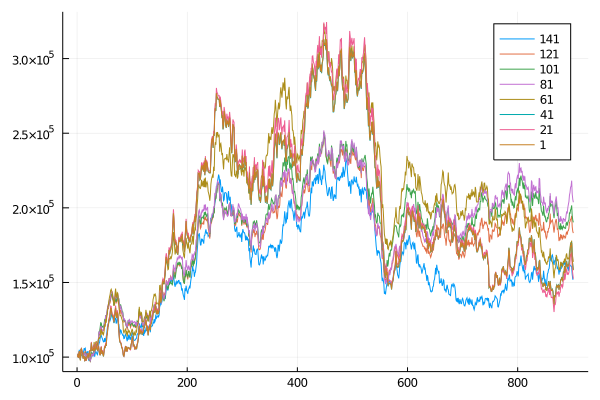

In [103]:
gr()
plot(asset_arr',lab = 201 .-len_ls')

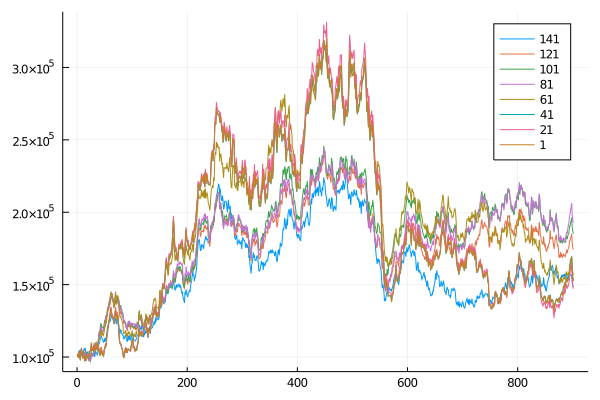

In [104]:
gr()
plot(asset_arr1',lab = 201 .-len_ls')

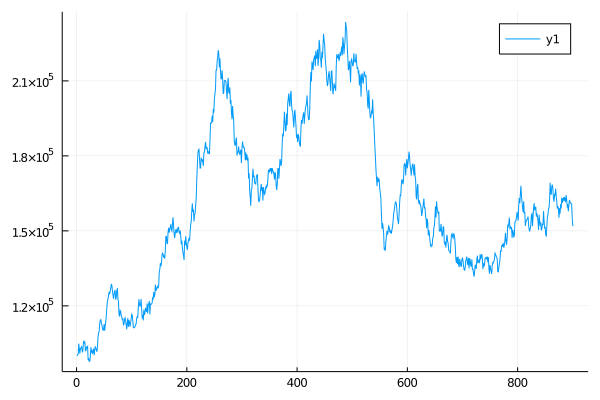

In [58]:
using Plots
gr()
plot(asset_arr[1,:])

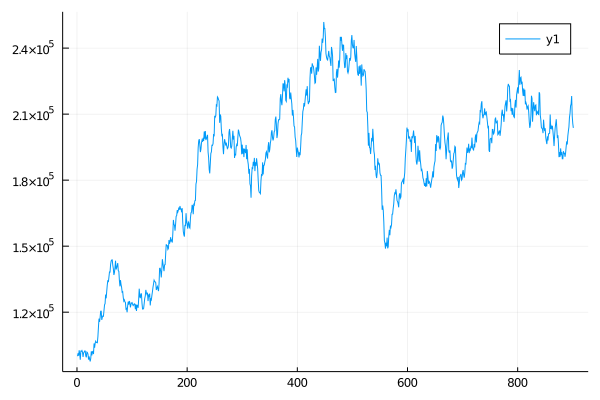

In [59]:
using Plots
gr()
plot(asset_arr[4,:])

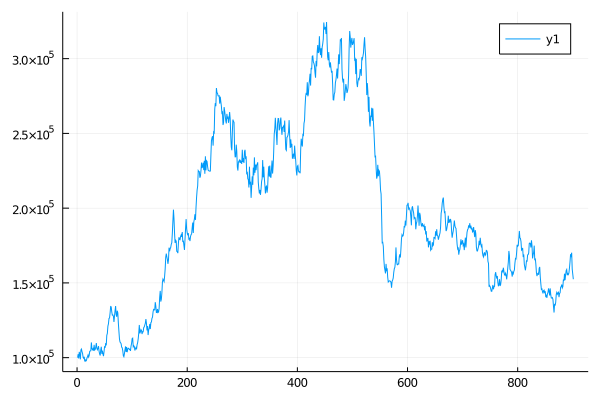

In [60]:
gr()
plot(asset_arr[7,:])

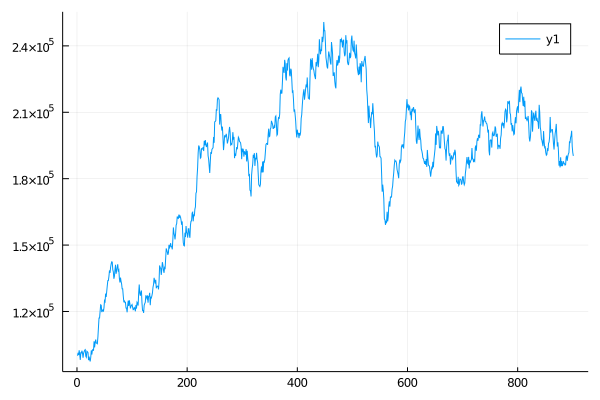

In [25]:
gr()
plot(asset_arr[3,:])

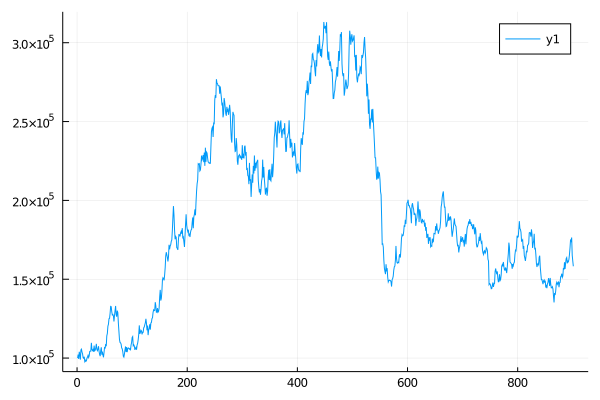

In [61]:
gr()
plot(asset_arr[8,:])

In [63]:
start = 1;
test_interval = 900;
win_len = 60
risk_free = 0.0001
asset = 100000.
threshold = 0.00001
asset_arr = Matrix{Float64}(undef,8,901)
len_ls = Vector(60:20:200)
for i in Vector(1:length(len_ls))
    tem=simulation_trade(start+200-len_ls[i], test_interval, len_ls[i], risk_free, asset, threshold)
    asset_arr[i,:] = vec(tem);
end

In [81]:
? plot

search: plot plot! plotly plot3d Plots plot3d! plotlyjs plotattr plotarea



The main plot command. Use `plot` to create a new plot object, and `plot!` to add to an existing one:

```
    plot(args...; kw...)                  # creates a new plot window, and sets it to be the current
    plot!(args...; kw...)                 # adds to the `current`
    plot!(plotobj, args...; kw...)        # adds to the plot `plotobj`
```

There are lots of ways to pass in data, and lots of keyword arguments... just try it and it will likely work as expected. When you pass in matrices, it splits by columns. To see the list of available attributes, use the `plotattr([attr])` function, where `attr` is the symbol `:Series:`, `:Subplot:`, `:Plot` or `:Axis`. Pass any attribute to `plotattr` as a String to look up its docstring; e.g. `plotattr("seriestype")`.


In [90]:
len_ls

8-element Array{Int64,1}:
  60
  80
 100
 120
 140
 160
 180
 200

In [88]:
[60 80 100 120 140 160 180 200]

1×8 Array{Int64,2}:
 60  80  100  120  140  160  180  200

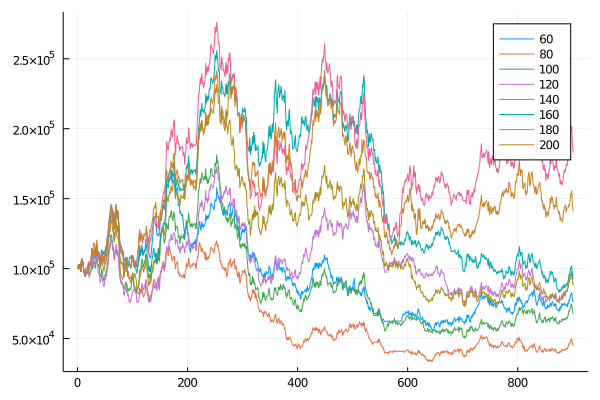

In [89]:
gr()
plot(asset_arr',lab = len_ls')

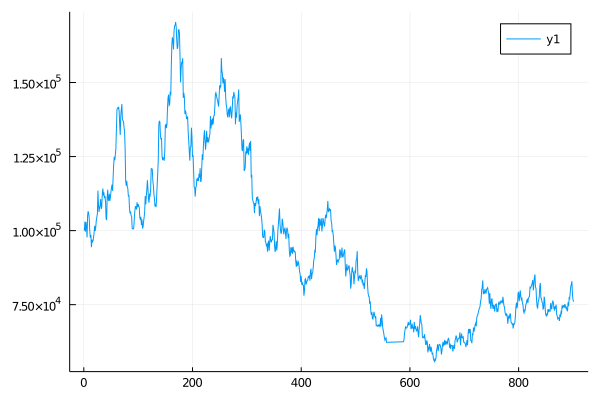

In [65]:
gr()
plot(asset_arr[1,:])

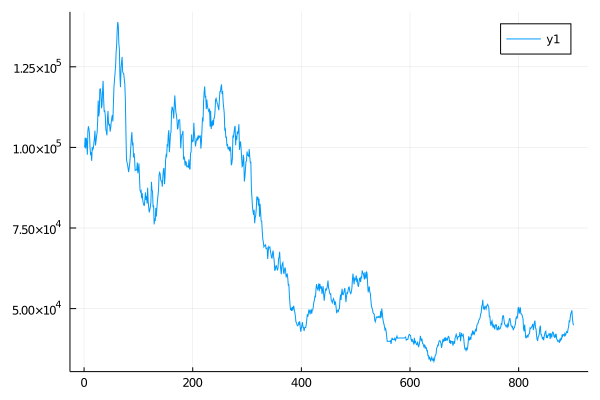

In [66]:
gr()
plot(asset_arr[2,:])

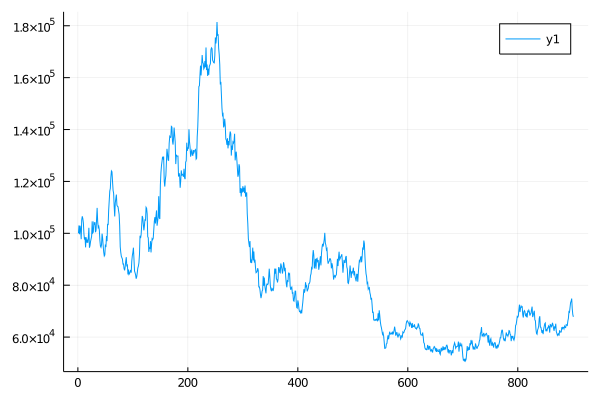

In [67]:
gr()
plot(asset_arr[3,:])

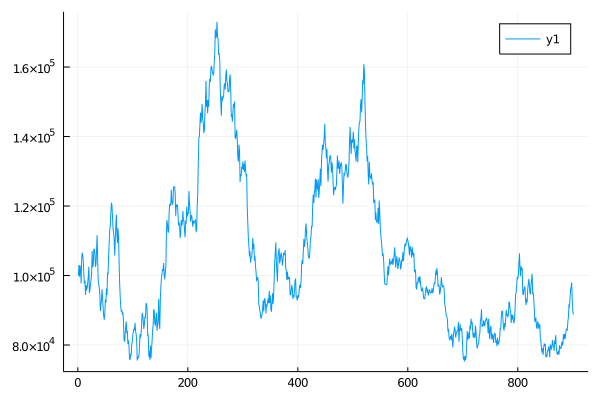

In [68]:
gr()
plot(asset_arr[4,:])

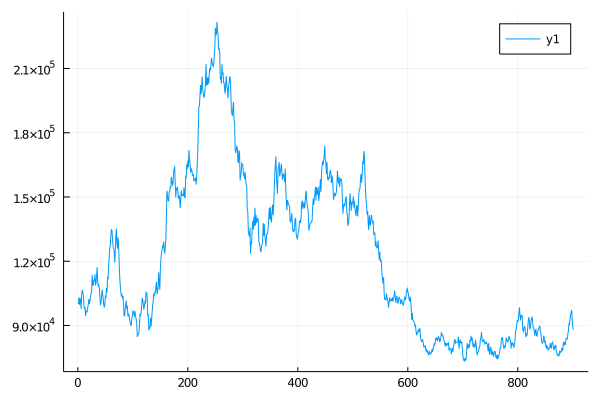

In [69]:
gr()
plot(asset_arr[5,:])

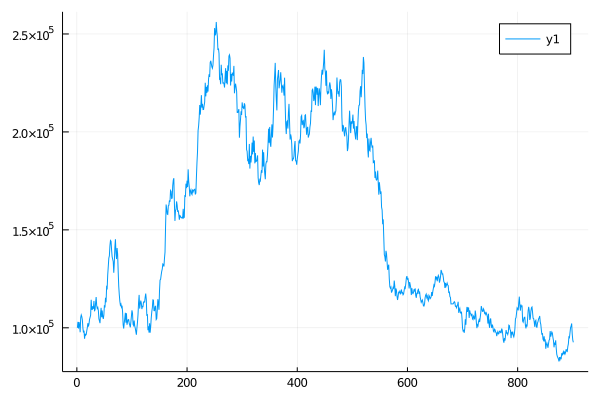

In [70]:
gr()
plot(asset_arr[6,:])

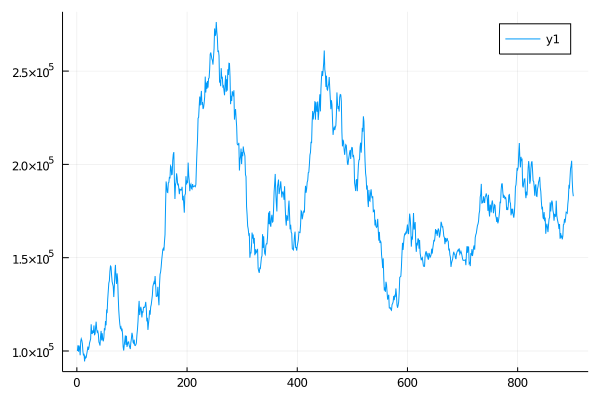

In [71]:
gr()
plot(asset_arr[7,:])

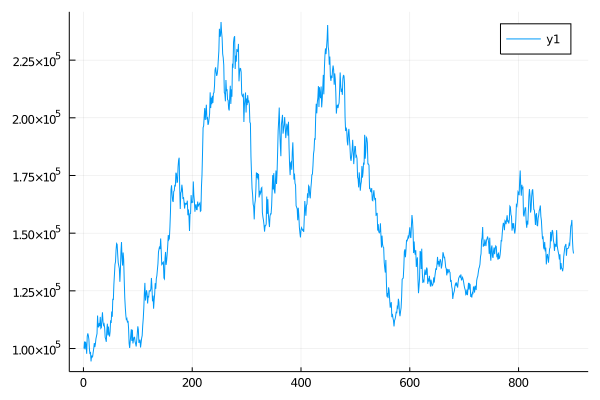

In [72]:
gr()
plot(asset_arr[8,:])

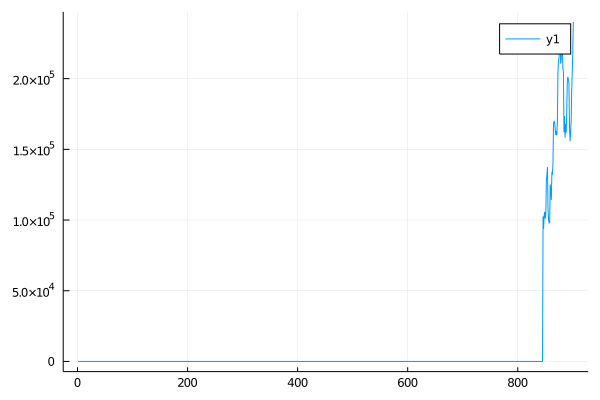

In [71]:
gr()
plot(asset_arr[8,:])

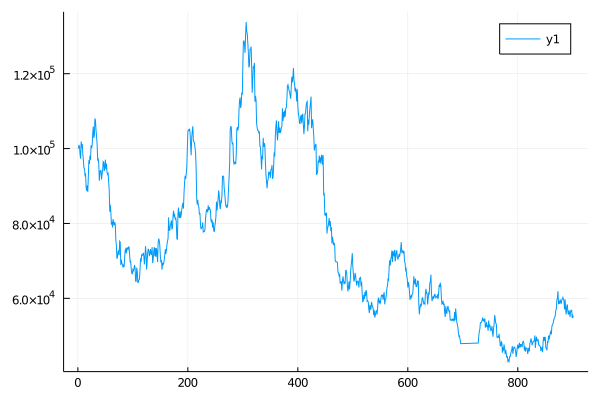

In [49]:
using Plots
gr()
plot(asset_arr[1,:])

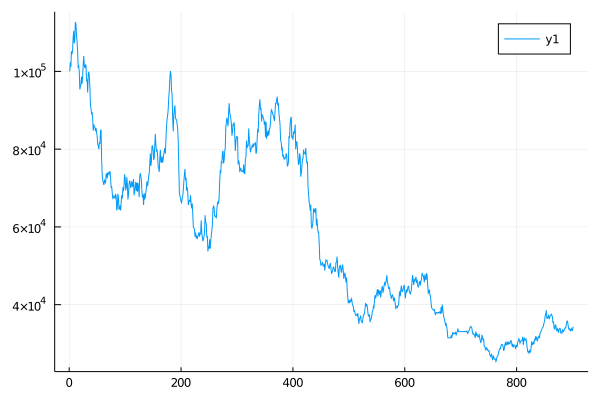

In [50]:
using Plots
gr()
plot(asset_arr[2,:])

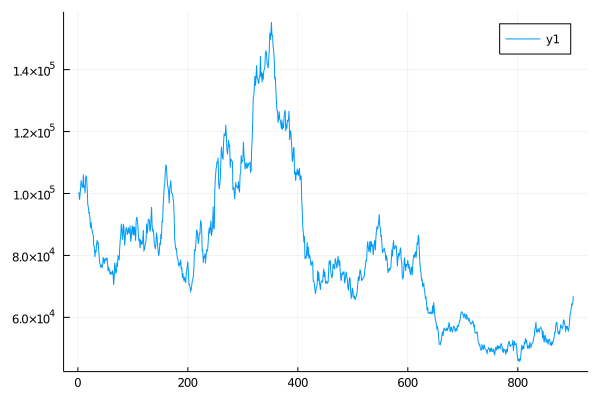

In [51]:
using Plots
gr()
plot(asset_arr[3,:])

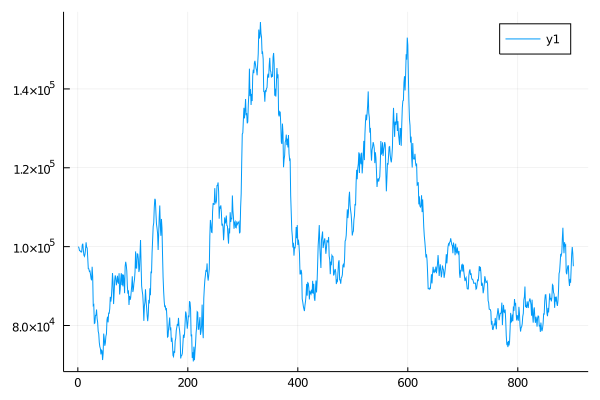

In [52]:
using Plots
gr()
plot(asset_arr[4,:])

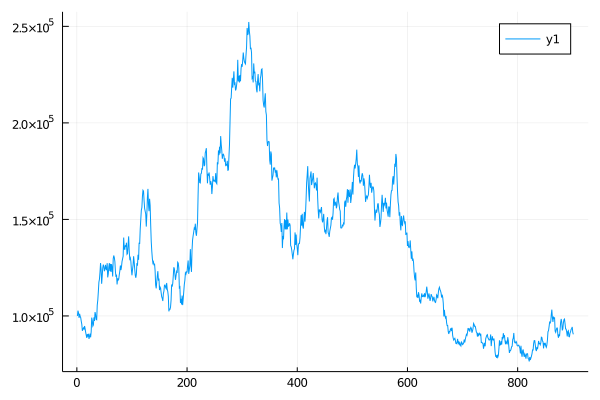

In [53]:
using Plots
gr()
plot(asset_arr[5,:])

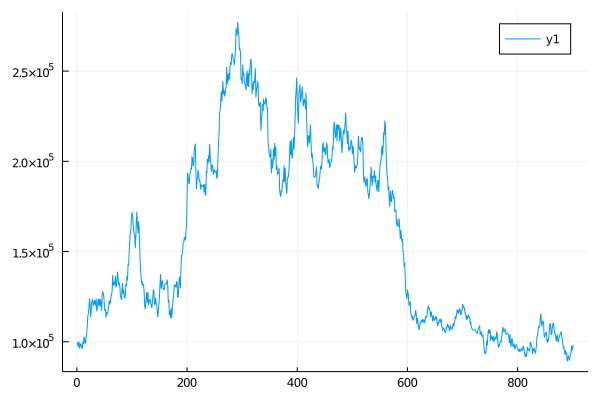

In [54]:
using Plots
gr()
plot(asset_arr[6,:])

In [39]:
tem=simulation_trade(start, test_interval, 200, risk_free, asset, threshold)

valid_fraction=[0.9999998875934591]


1×901 Array{Float64,2}:
 100000.0  103301.0  1.01701e5  98075.3  …  1.37638e5  1.36138e5  1.34997e5

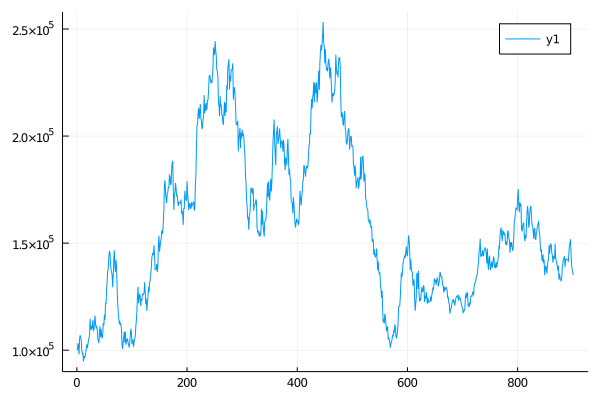

In [40]:
plot(vec(tem))

In [56]:
size(df_v)

(1457, 80)

In [39]:
Vector(60:20:160)

6-element Array{Int64,1}:
  60
  80
 100
 120
 140
 160

In [42]:
start = 1;
test_interval = 900;
win_len = 60
risk_free = 0.0001
asset = 100000.
threshold = 0.00001
asset_arr = Matrix{Float64}(undef,6,901)
len_ls = Vector(60:20:160)
for i in Vector(1:length(len_ls))
    tem=simulation_trade(start, test_interval, len_ls[i], risk_free, asset, threshold)
    asset_arr[i,:] = vec(tem);
end

valid_fraction=[0.9999991597706143]
valid_fraction=[0.9999998589693091]
valid_fraction=[0.07920431144961156, 0.6380823941331977, 0.2826947561925744]
valid_fraction=[0.8127531829615318, 0.1872020788615382]
valid_fraction=[0.004565000312956405, 0.012317382254272768, 0.983127916898413]
valid_fraction=[0.9999996421687144]


In [47]:
findmax(asset_arr,dims=2)[1]

6×1 Array{Float64,2}:
 122651.77784277622
 110115.3793962674
 161700.63164634546
 149268.74907745348
 247803.83657661892
 264307.68328913493

In [48]:
findmax(asset_arr,dims=2)[2]

6×1 Array{CartesianIndex{2},2}:
 CartesianIndex(1, 391)
 CartesianIndex(2, 10)
 CartesianIndex(3, 351)
 CartesianIndex(4, 331)
 CartesianIndex(5, 311)
 CartesianIndex(6, 291)

In [37]:
asset_arr[1,:] = vec(tem);

In [21]:
struct Order
    id_v :: Array{Int64,1}
    stock_f :: Array{Float64,1}
    cash_f :: Float64
end 

In [22]:
order_ls=Vector{Order}(undef, test_interval);

In [23]:
order_ls[1]=Order(id_v,valid_fraction,fraction_raw[end]);

In [24]:
size(asset_arr)

(1, 901)

In [38]:
start = 1;
test_interval = 900;
win_len=1200
win_len2=60
risk_free=0.0001
asset=100000
fraction_raw=single_win_frac(df_v,start,win_len,risk_free)
id_v=fra_filter(fraction_raw[1:end-1],0.0001)
valid_fraction=fraction_raw[id_v]
price=df_p[win_len2+2+start,id_v]
stock_num=asset_allocate(asset,valid_fraction,price)
asset_arr=[asset]

1-element Array{Int64,1}:
 100000

In [42]:
asset=100000
asset_fra=asset*valid_fraction

2-element Array{Float64,1}:
 55219.783563126926
 44781.23722810461

In [44]:
sum(asset_fra)

100001.02079123154

In [58]:
100000*valid_fraction

2-element Array{Float64,1}:
 55219.783563126926
 44781.23722810461

In [43]:
stock_num1=asset_fra ./ df_p[win_len2+2+start,id_v]

2-element Array{Float64,1}:
 354.8884355752184
 385.51392431615864

In [40]:
price_n=df_p[win_len2+1+2+start,id_v]

2-element Array{Float64,1}:
 154.1237762998617
 113.71856844051517

In [45]:
asset_n=stock_num1' * price_n

98536.83744312152

In [ ]:
asset_n

In [61]:
asset_n*valid_fraction ./price_n

2-element Array{Float64,1}:
 353.0398078241919
 388.02823090019683

In [59]:
asset_n*valid_fraction

2-element Array{Float64,1}:
 54411.82836604191
 44126.01493247606

In [47]:
asset=total_asset(asset,stock_num,price_n,valid_fraction,risk_free)

98535.81665188998

In [48]:
asset_fra2=asset*valid_fraction

2-element Array{Float64,1}:
 54411.26468733323
 44125.55780953306

In [53]:
price_n

2-element Array{Float64,1}:
 154.1237762998617
 113.71856844051517

In [55]:
asset_fra2[2] / price_n[2]

388.0242111262121

In [56]:
asset_fra2[2]

44125.55780953306

In [49]:
asset_fra2 ./ price_n

2-element Array{Float64,1}:
 353.0361505123726
 388.0242111262121

In [52]:
asset_n-asset

1.020791231538169

In [50]:
stock_num1

2-element Array{Float64,1}:
 354.8884355752184
 385.51392431615864

In [37]:
start = 1;
test_interval = 900;
win_len=1200
win_len2=60
risk_free=0.0001
asset=100000
fraction_raw=single_win_frac(df_v,start,win_len,risk_free)
id_v=fra_filter(fraction_raw[1:end-1],0.0001)
valid_fraction=fraction_raw[id_v]
price=df_p[win_len2+2+start,id_v]
stock_num=asset_allocate(asset,valid_fraction,price)
asset_arr=[asset]
for i=1:test_interval
    if length(id_v)>0
        price_n=df_p[win_len2+i+2+start,id_v]
        asset=total_asset(asset,stock_num,price_n,valid_fraction,risk_free)
    else
        asset=asset*(1+risk_free)
    end
    print("asset1=",stock_num'*price_n,"\n")
    print("stock_num=",stock_num,"\n")
    fraction_raw=single_win_frac(df_v,start,win_len,risk_free)
    id_v=fra_filter(fraction_raw[1:end-1],0.0001)
    valid_fraction=fraction_raw[id_v]
    price_s=df_p[win_len2+i+2+start,id_v]
    stock_num=asset_allocate(asset,valid_fraction,price_s)
    print("asset1=",sum(asset*valid_fraction),"\n")
    stock_num2=asset*valid_fraction ./ price_s
    print("stock_num=",stock_num2,"\n")
    print("asset2=",stock_num2'*price_s,"\n")
    asset_arr=[asset_arr asset]
end

asset1=98536.83744312152
stock_vol=[354.8884355752184, 385.51392431615864]
asset1=98536.82249686628
stock_vol=[353.0361505123726, 388.0242111262121]
asset2=98536.82249686628
asset1=98159.68335321968
stock_vol=[353.0361505123726, 388.0242111262121]
asset1=98159.67950341635
stock_vol=[354.8824588292854, 385.55074605933873]
asset2=98159.67950341635
asset1=94885.62413465354
stock_vol=[354.8824588292854, 385.55074605933873]
asset1=94885.5907133834
stock_vol=[354.14570642587086, 386.5420383834366]
asset2=94885.5907133834
asset1=98273.41640273502
stock_vol=[354.14570642587086, 386.5420383834366]
asset1=98273.4509853626
stock_vol=[354.4548971064223, 386.1270109471133]
asset2=98273.4509853626
asset1=98705.16269346698
stock_vol=[354.4548971064223, 386.1270109471133]
asset1=98705.16710034222
stock_vol=[356.2506399585094, 383.74184119140733]
asset2=98705.16710034222
asset1=97291.38852247596
stock_vol=[356.2506399585094, 383.74184119140733]
asset1=97291.37409074818
stock_vol=[364.7553266956101, 373

In [32]:
price_s

LoadError: UndefVarError: price_s not defined

In [43]:
size(df_p)

(1458, 80)

In [36]:
df_s_p=df_p[win_len2+2+start:test_interval,id_v];

In [37]:
res2=df_s_p*(100000.0 .*valid_fraction./df_s_p[1,:]);

In [38]:
size(res2)

(838,)

In [39]:
res2[800:end]

39-element Array{Float64,1}:
 213642.33321728613
 219892.70292338933
 223034.69159818592
 223729.8695376349
 216213.9474343258
 213212.00227172446
 214476.3323934481
 205707.68433595606
 199505.34729352515
 202438.92100082987
 204514.13170252932
 209102.41539756636
 216318.77035345667
      ⋮
 199194.87655198376
 192051.44313639074
 188755.79037163814
 189620.81997055144
 184263.84481462784
 186272.95800307882
 186128.24128122546
 190236.09200675765
 194687.53904489928
 191270.4257904744
 192770.90718730714
 194353.31286698784

In [22]:
start = 1;
test_interval = 900;
win_len=60
risk_free=0.0001
asset=100000
id_v_arr=Array[]
fraction_raw=single_win_frac(df_v,start,win_len,risk_free)
id_v=fra_filter(fraction_raw[1:end-1],0.0001)
id_v_arr=Array[id_v_arr,id_v]
valid_fraction=fraction_raw[id_v]
price=df_p[win_len+2+start,id_v]
stock_num=asset_allocate(asset,valid_fraction,price)
#price=df_p[win_len+2,id_v]
asset_arr=[asset]
for i=1:test_interval
    if length(id_v)>0
        price_n=df_p[win_len+i+2+start,id_v]
        asset=total_asset(asset,stock_num,price_n,risk_free)
    else
        asset=asset*(1+risk_free)
    end
    fraction_raw=single_win_frac(df_v,start+i,win_len,risk_free)
    id_v=fra_filter(fraction_raw[1:end-1],0.0001)
    id_v_arr=[id_v_arr,id_v]
    valid_fraction=fraction_raw[id_v]
    price_s=df_p[win_len+i+2+start,id_v]
    stock_num=asset_allocate(asset,valid_fraction,price_s)
    asset_arr=[asset_arr asset]
end

100386.76018905835

In [30]:
asset_arr

1×901 Array{Float64,2}:
 100000.0  1.0e5  1.0e5  1.0e5  99999.9  …  100387.0  1.00387e5  1.00387e5

In [ ]:
single_win

In [69]:
valid_fraction

3-element Array{Float64,1}:
 -2.192615645215929e-8
  0.968101422271971
  1.7604286345379612e-7

In [70]:
id_v=fra_filter(fraction_raw[1:end-1],0.0001)

2-element Array{Int64,1}:
  2
 75

In [25]:
eff_fra=fraction_raw[id_v]

1-element Array{Float64,1}:
 1.000001657679251

In [68]:
id_v

2-element Array{Int64,1}:
  2
 75

In [66]:
price

1-element Array{Float64,1}:
 8.450605999150605

In [60]:
price

1-element Array{Float64,1}:
 8.450605999150605

In [61]:
id_v

2-element Array{Int64,1}:
  2
 75

1-element Array{Array{Int64,1},1}:
 [2, 75]

In [57]:
id_v

2-element Array{Int64,1}:
  2
 75

In [56]:
price_n=df_p[win_len+i+2,id_v]

LoadError: UndefVarError: i not defined

In [49]:
100000*(1+risk_free)^900

109416.93602602275

In [51]:
asset_arr[1:50]

50-element Array{Float64,1}:
 100000.0
  99999.90220353754
  99999.8580839532
 100000.0231464112
 100000.2923928147
 100000.10074480044
 100000.08177250504
  99999.96147089619
  99995.58276567799
  99995.89079400756
  99996.4066152299
  99469.61250448972
  99143.07093543233
      ⋮
  90636.26347076474
  90315.4399846727
  89993.74023839412
  89677.11588130845
  89677.85142548401
  89679.88921269016
  89681.86158100901
  89683.65320412019
  89685.46043483054
  89687.44258761319
  89689.33971410431
  89690.09121086002

In [48]:
asset

28788.094080989526

In [56]:
start = 0;
test_interval = 900;
win_len=60
risk_free=0.0001
asset=100000
fra_res=[]
id_v_res=[]
for i=1:test_interval
    start=start+1
    if start+win_len > size(df_v)[1] #check boundary
        println(start)
        break
    end
    fraction_raw=single_win(df_v,start,win_len,risk_free)
    id_v=fra_filter(fraction_raw,0.0001)
    id_v_res=[id_v_res,id_v]
    valid_fraction=fraction_raw[id_v]
    stock_num=asset_allocate(asset,fraction_raw,price)
    asset_tem=total_asset(asset,stock_num,new_price,rate)
    fra_res=[fra_res,valid_fraction]
end

In [57]:
start

900

In [40]:
test_start=test_start+11
win1=get_win(df_v,test_start,60);
cov1=cov(win1);
mu1=DataFrames.mean(win1,dims=1);
mu_c=hcat(mu1,0.0001);
cov_rf=cov_addcash(cov1);
fraction_raw=vec(opt_solver(mu_c,cov_rf));
id_v=fra_filter(fraction_raw,0.0001)

1-element Array{Int64,1}:
 26

In [38]:
fraction_raw[id_v]

1-element Array{Float64,1}:
 0.9999978025737778

In [108]:
all(a.>=0)

false